# Laboratorium nr 13

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

from PIL import Image
from pathlib import Path

## Wprowadzenie do sieci konwolucyjnych (na bazie materiału przygotowanego przez Grzegorza Wilczyńskiego)

### a) Czym jest Konwolucja?

Omówimy tutaj konwolucję w jednym wymiarze jednak rozszerzenie do wyższej ilości wymiarów jest trywialne.

[Źródło](https://jinglescode.github.io/2020/11/01/how-convolutional-layers-work-deep-learning-neural-networks/)

Konwolucja to operacja liniowa polegająca na mnożeniu WAG z danymi wejściowymi generując wyjście. Mnożenie jest przeprowadzone między tablicą (arrayem) danych wejściowych i arrayem wag, zwanych jądrem (kernelem) lub filtrem. Operacja stosowana między danymi wejściowymi a jądrem to tak naprawdę iloczyn skalarny. Wynikiem każdej operacji jest pojedyncza wartość.

Zacznijmy od najprostszego przykładu, używając konwolucji 1D gdy masz dane 1D. Zastosowanie konwolucji na arrayu 1D to tak naprawdę przemnożenie wartości w kernelu (jądrze) przez każdą wartość w wektorze wejściowym.

Załóżmy, że kernel ma długość 1 i jego jedyną wartością jest `2`. W ramach konwolucji przemnożymy każdy element wejściowy przez wartość `2` uzyskując nowy wektor o tej samej długości co wejściowy.

![](https://jinglescode.github.io/assets/img/posts/how-convolutional-layers-work-deep-learning-neural-networks-02.gif)

Najpierw mnożymy 1 przez wagę 2 i dostajemy 2 jako pierwszy element wyjścia. Następnie przesuwamy kernel o 1 miejsce w prawo i powtarzamy proces dostając tym razem wartość 4. Powtarzamy ten proces aż w końcu otrzymujemy wartość końcową równą 12.

#### **Efekt rozmiaru jądra** (`kernel_size = 2`)

Różne rozmiary jądra wejściowego znajdują cechy sygnału wejściowego o różnych rozmiarach, co z kolei powoduje powstawanie map cech (chodzi o wyjście operacji konwolucji) o różnych rozmiarach. Popatrzmy na przykład, gdzie rozmiar jądra to 1x2 z wagami o wartości 2. Jak przedtem, przesuwamy jądro przez wektor wejściowy przemnażając wszystkie wartości wejściowe (zauważ, że niektóre wartości sygnału wejściowego są mnożone więcej razy niż inne). Wykonujemy konwolucję, mnożąc każdy element przez jądro i dodając do siebie wyniki mnożenia aby uzyskać końcową wartość. Powtarzamy to mnożenie i dodawanie, jedno po drugim, generując wyjściowy wektor.

![](https://jinglescode.github.io/assets/img/posts/how-convolutional-layers-work-deep-learning-neural-networks-03.gif)

#### **Jak obliczyć rozmiar wektora wyjściowego?**

Jak widać, rozmiar wyjścia jest mniejszy niż poprzednio. To przez większy rozmiar jądra. Patrząc na dokumentacje PyTorcha możemy obliczyć długość wektora wyjściowego zgodnie ze wzorem:

![](https://jinglescode.github.io/assets/img/posts/how-convolutional-layers-work-deep-learning-neural-networks-09.png)

Jeżeli aplikujemy jądro o rozmiarze 2, do wejściowego wektora o rozmiarze 6 to podstawiając odpowiednie wartości dostajemy wyjściowy wektor o długości 5.

![](https://jinglescode.github.io/assets/img/posts/how-convolutional-layers-work-deep-learning-neural-networks-10.png)

Ważna kwestia - padding jest równy 0, dilation jest równe 1 oraz stride jest równe 1.

#### **Zazwyczaj kernele mają nieparzyste rozmiary**

Typowym rozmiarem jest np. `kernel_size=3`.

![](https://jinglescode.github.io/assets/img/posts/how-convolutional-layers-work-deep-learning-neural-networks-04.gif)

Jak widać ta operacja jest identyczna jak w poprzednich przypadkach.

#### **Jak wygenerować wyjściowy wektor o tym samym rozmiarze co wejściowy?**

Stosowanie konwolucji z kernelem o rozmiarze 3 i wejściem o długości 6 da nam krótszy wektor o długości 4. Domyślnie jądro zaczyna po lewej stronie wektora, przesuwa się przez wektor wejściowy po jednym elemencie na raz, aż najbardziej wysunięty na prawo element jądra znajdzie się na ostatnim elemencie wektora wejściowego. Zatem im większy rozmiar jądra tym mniejszy będzie wektor wyjściowy.

Czasami jednak chcemy żeby wektor wyjściowy miał ten sam rozmiar co sygnał wejściowy. Też możemy chcieć żeby każdy element wektora wejściowego był analizowany tyle samo razy. Możemy to osiągnąć stosując **PADDING**. Padding to dodawanie zer (lub innych wartości) na początku i końcu wektora wejściowego.

Stosując padding o rozmiarze 1 dla wektora wejściowego o rozmiarze 6 otrzymujemy wektor o rozmiarze 8. Dodajemy po prostu po jednym zerze na początku i końcu. Wykonując konwolucje z rozmiarem kernela 3, wektor wyjściowy ma teraz ten sam rozmiar jak wejściowy. Używanie wypełnienia zerami przy paddingu sprawia, że po mnożeniu a podczas dodawania dodajemy wartość 0 co zupełnie nie ma wpływu na działanie iloczynu skalarnego po zastosowaniu kernela.

![](https://jinglescode.github.io/assets/img/posts/how-convolutional-layers-work-deep-learning-neural-networks-05.gif)

#### **Przesuwanie kernela o większy krok niż 1**

Do tej pory przesuwaliśmy jądro o krok 1. Jednak oczywiście możemy robić to z większym krokiem!

Na przykład możemy przesunąć nasze jądro o krok 3. W rezultacie nasz wektor wyjściowy (w przykładzie poniżej) będzie miał rozmiar 2 (zgodnie ze wzorem).

![](https://jinglescode.github.io/assets/img/posts/how-convolutional-layers-work-deep-learning-neural-networks-06.gif)

Kiedy zwiększać rozmiar kroku? W większości przypadków stosuje się większy stride gdy chcemy analizować dane ale przy okazji zmniejszać ich rozmiar.

---

### b) Czym jest warstwa poolingowa?

[Źródło](https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/)

Warstwa poolingowa służy do zmniejszania rozmiaru wektorów (lub macierzy czy tensorów). Zasadniczo działa identycznie jak konwolucja z tym, że nie przemnażamy wektora wejściowego przez jądro tylko wykonujemy na danym fragmencie tego wektora jakąś operację.

Wyróżniamy dwa główne rodzaje poolingu: max i average pooling.

**Max pooling**

Na obrazku poniżej mamy tabice wejściową, której rozmiar jest 4x4. Rozmiar naszego okna (kernela) to 2x2 a stride (krok) wynosi też 2x2 (to znaczy, że przesuwamy się poziomo o krok równy 2 i pionowo o krok równy 2).

Każdy kolor na tej tablicy wejściowej pokazuje unikalną pozycję filtra. Jak widać z obszaru niebieskiego wyciągamy tylko jedną wartość i jest to wartość maksymalna (czyli 9). To samo dzieje się dla innych obszarów: dla zielonego 7, dla żółtego 8 a dla czerwonego 6.

W ten sposób zmniejszyliśmy rozmiar naszego wejścia dwukrotnie w każdym wymiarze (a finalnie mamy 4x mniej wartości).

![](https://media.geeksforgeeks.org/wp-content/uploads/20190721025744/Screenshot-2019-07-21-at-2.57.13-AM.png)

**Average pooling**

Tutaj sprawa wygląda identycznie jak powyżej z tym, że zamiast brać wartość maksymalną - liczymy średnią z okna.

![](https://media.geeksforgeeks.org/wp-content/uploads/20190721030705/Screenshot-2019-07-21-at-3.05.56-AM.png)

---

### c) Podsumowanie architektury CNN i kluczowych koncepcji

[Źródło](https://medium.com/data-science/basics-of-the-classic-cnn-a3dce1225add)

**Podstawowa architektura**
- Warstwy konwolucyjne: Wykorzystują operacje konwolucji do ekstrakcji cech przestrzennych (np. krawędzie, tekstury). Zachowują relacje przestrzenne i redukują liczbę parametrów dzięki współdzieleniu wag (np. do analizy obrazu nie potrzebujemy wagi dla każdego piksela wejściowego tylko mamy jedno jądro analizujące cały obraz).
- Wastwy aktywacyjne: Wprowadzają nieliniowość, umożliwiając wykrywanie bardziej złożonych wzorców (np. ReLU, Leaky ReLU, SeLU, tanh, etc.)
- Warstwy poolingowe (max/average): Zmniejszają rozdzielczość map cech, redukując obciążenie obliczeniowe i zapobiegają overfittingowi (np. max pooling zachowuje dominujące cechy sygnału)
- Warstwy klasyfikacyjne (fully connected): Gdy nasz sygnał jest przeworzony przez kilka (kilkanaście lub kilkadziesiąt) warstw konwolucyjnych zostaje nam jakiś tensor o pewnym rozmiarze (zobaczysz później jak to wygląda). Na podstawie tej informacji chcemy przeprowadzić jakąś operację - np. klasyfikacje. Aby to zrobić spłaszczamy nasz sygnał a potem dajemy go na wejście warstw MLP (fully connected) aby uzyskać finalną klasyfikację (np. którą cyfrę zawiera dane zdjęcie dla zbioru danych MNIST).

![](https://miro.medium.com/v2/resize:fit:786/format:webp/1*kkyW7BR5FZJq4_oBTx3OPQ.png)

**Dlaczego stosuje się CNN?**
- Hierarchia przestrzenna: Wychwytują lokalne wzorce (krawędzie -> kształty -> obiekty) poprzed nakładanie warstw konwolucyjnych. Tzn. warstwy początkowe wykrywają bardzo proste wzorce typu linia krzywa, prosta, lekko zakrzywiona, późniejsze wykrywają bardziej skomplikowane (np. okrąg, etc) a jeszcze późniejsze już konkretne kształty (np. rower, samochód, twarz człowieka, etc.). Co ciekawe jest to działanie inspirowane zmysłem wzroku ssaków, które działa na tej samej zasadzie.

![](https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/creative-assets/s-migr/ul/g/41/0f/hierarchy.png)

- Efektywność parametrów: Współdzielenie wag w konwolucjach redukuje liczbę parametrów w porównaniu z sieciami MLP.
- Niezmienność względem przesunięć: Dzięki operacji konwolucji jeżeli jedno zdjęcie przedstawia cyfrę 9, a drugie jest dokładnie tym samym tylko przesuniętym o 5 pikseli w prawo to zostaną one dokładnie tak samo sklasyfikowane. Gdybyśmy do tego zadania użyli sieci MLP wynik byłby zgoła inny.

**Typy sygnałów**
- CNN 1D: Przetwarzają dane sekwencyjne (audio, szeregi czasowe, etc.) przy użyciu filtrów 1D.
- CNN 2D: Klasyczne zastosowanie dla analizy obrazu
- CNN 3D: Obsługują dane z dodatkowym wymiarem (np. film, skany MRI) z użyciem filtrów 3D, wychwytując cechy przestrzenno-czasowe.

## Podsumowując

Warto korzystać z CNNów bo automatycznie wykrywają hierarchiczne cechy (np. krawędzie, kształty) w danych przestrzennych lub sekwencyjnych, redukując potrzebę ręcznej ekstrakcji. Dzięki współdzieleniu wag i poolingowi są niesamowicie efektywne obliczeniowo i odporne na przesunięcia sygnału (np. obiektów na obrazie). Są popularne dzięki rewolucyjnym zastosowaniom (np. pierwsza komercyjnie wykorzystana sieć już w latach 90 LeNet), adaptacyjności do różnych danych (1D/2D/3D), wsparciu frameworków oraz przełomowym architekturom (ResNet, YOLO), które napędzają m.in. medycynę, autonomiczne pojazdy, etc.

---

### Zadanie nr 1 (1 punk)
Zaimplementuj funkcję konwolucji 1D, która:

1. Przyjmuje jako argumenty: tensor danych wejściowych, tensor jądra (kernel), krok (stride) i padding

2. Stosuje padding, jezeli w ogóle ma być robiony, poprzez dołączenie zer do wejścia

3. Oblicza długość wyjścia na podstawie rozmiaru wejścia, rozmiaru jądra i kroku ((wysokość_wejścia - wysokość_kernela) // stride + 1)

4. Dla każdej wartości wyjściowej:

   - Pobiera wycinek danych wejściowych o rozmiarze jądra

   - Mnoży element po elemencie z jądrem (element-wise)

   - Sumuje wyniki

5. Zwraca tensor wyjściowy konwolucji

Przykład:
```
Wejście: [1,2,3,4,5], Jądro: [1,0.5], Krok: 1, Padding: 1
- Z padding=1: [0,1,2,3,4,5,0]
- Długość wyjścia = (7-2)/1 + 1 = 6
- Wyjście[0] = 0*1 + 1*0.5 = 0.5
- Wyjście[1] = 1*1 + 2*0.5 = 2.0
I tak dalej...
```

Po zaimplementowaniu proszę uruchomić komórkę z weryfikacją w celu sprawdzenia, czy implementacja jest poprawna.

In [2]:
import torch

def manual_conv1d(input_data, kernel, stride=1, padding=0):
    if padding:
        data = torch.cat(
            [
                torch.zeros(padding, dtype=input_data.dtype, device=input_data.device),
                input_data,
                torch.zeros(padding, dtype=input_data.dtype, device=input_data.device),
            ],
            dim=0,
        )
    else:
        data = input_data

    input_len = data.shape[0]
    kernel_len = kernel.shape[0]
    output_len = (input_len - kernel_len) // stride + 1

    output = torch.zeros(output_len, dtype=data.dtype, device=data.device)

    for i in range(output_len):
        start = i * stride
        end = start + kernel_len
        window = data[start:end]
        output[i] = (window * kernel).sum()

    return output


In [4]:
# weryfikacja

input_1d = torch.tensor([1.,2,3,4,5])
kernel_1d = torch.tensor([1.,0.5])
pad, strd = 1, 1

manual_out = manual_conv1d(input_1d, kernel_1d, pad, strd)
print(manual_out)

conv1d = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=1, bias=False)  # we didn't implement bias
conv1d.weight.data = kernel_1d.view(1,1,-1)
torch_out = conv1d(input_1d.view(1,1,-1)).squeeze()

print(torch_out)

tensor([0.5000, 2.0000, 3.5000, 5.0000, 6.5000, 5.0000])
tensor([0.5000, 2.0000, 3.5000, 5.0000, 6.5000, 5.0000],
       grad_fn=<SqueezeBackward0>)


### Zadanie nr 2 (1 punkt)
Proszę zaimplementować teraz konwolucję 2D, która jest rozszerzeniem konwolucji 1D na dwa wymiary.

Kroki implementacji:

1. Dodanie paddingu:

   - Dodajemy zera wokół macierzy wejściowej (jeśli padding > 0)

   - Musimy dodać padding zarówno w pionie jak i w poziomie

2. Obliczenie wymiarów wyjścia:

   - Wysokość wyjścia = (wysokość_wejścia - wysokość_kernela) // stride + 1

   - Szerokość wyjścia = (szerokość_wejścia - szerokość_kernela) // stride + 1

3. Wykonanie konwolucji:

   - Dla każdej pozycji wyjściowej:

     * Wycinamy fragment danych wejściowych o rozmiarze kernela

     * Mnożymy element po elemencie z kernelem

     * Sumujemy wszystkie otrzymane wartości

     * Zapisujemy wynik w odpowiedniej pozycji macierzy wyjściowej

Po zaimplementowaniu proszę uruchomić komórkę z weryfikacją w celu sprawdzenia, czy implementacja jest poprawna.

In [5]:
import torch

def manual_conv2d(input_data, kernel, stride=1, padding=0):
    if padding:
        # Pad w poziomie (lewo/prawo)
        data = torch.cat([
            torch.zeros(input_data.shape[0], padding, dtype=input_data.dtype, device=input_data.device),
            input_data,
            torch.zeros(input_data.shape[0], padding, dtype=input_data.dtype, device=input_data.device),
        ], dim=1)

        # Pad w pionie (góra/dół)
        data = torch.cat([
            torch.zeros(padding, data.shape[1], dtype=input_data.dtype, device=input_data.device),
            data,
            torch.zeros(padding, data.shape[1], dtype=input_data.dtype, device=input_data.device),
        ], dim=0)
    else:
        data = input_data

    input_h, input_w = data.shape
    kernel_h, kernel_w = kernel.shape

    output_h = (input_h - kernel_h) // stride + 1
    output_w = (input_w - kernel_w) // stride + 1

    output = torch.zeros(output_h, output_w, dtype=data.dtype, device=data.device)

    for i in range(output_h):
        for j in range(output_w):
            patch = data[i*stride:i*stride+kernel_h, j*stride:j*stride+kernel_w]
            output[i, j] = (patch * kernel).sum()

    return output


In [6]:
input_2d = torch.tensor([[1.,2,3],[4,5,6],[7,8,9]])
kernel_2d = torch.tensor([[0.,1],[2,3]])
pad, strd = 1, 2

manual_out = manual_conv2d(input_2d, kernel_2d, strd, pad)
print(manual_out)

conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, stride=strd, padding=pad, bias=False)
conv2d.weight.data = kernel_2d.view(1,1,2,2)
torch_out = conv2d(input_2d.view(1,1,3,3)).squeeze()
print(torch_out)

tensor([[ 3., 13.],
        [25., 49.]])
tensor([[ 3., 13.],
        [25., 49.]], grad_fn=<SqueezeBackward0>)


## Learning rate scheduler

Stała ucząca (ang. learning rate) to jeden z kluczowych hiperparametrów w uczeniu maszynowym, kontrolujący wielkość kroku, jaki model wykonuje podczas aktualizacji wag w procesie optymalizacji. Learning rate scheduler to technika dynamicznego dostosowywania tempa uczenia (poprzez modyfikację stałej uczącej) w trakcie treningu modelu, aby poprawić jego skuteczność i przyspieszyć zbieżność. Celem jest znalezienie odpowiedniego balansu między szybkim uczeniem na początku treningu a precyzyjnym dostrajaniem w późniejszych etapach treningu.

### Zalety schedulowania stałej uczącej podczas treningu:

- Wysokie tempo uczenia na początku pozwala modelowi szybko zbliżyć się do minimum funkcji straty.

- Unikanie oscylacji: Zbyt wysokie tempo uczenia w późniejszych etapach może powodować niestabilność.

### Popularne schedulery

1. StepLR - stała ucząca jest mnożona przez stały czynnik (np. 0.9) co określoną liczbę epok.

In [ ]:
model = nn.Linear(10, 1)
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for epoch in range(30):
    # Trening modelu...
    optimizer.step()
    scheduler.step()  # Aktualizacja tempa uczenia co epokę
    print(f"Epoka {epoch+1}, Aktualne LR: {scheduler.get_last_lr()[0]}")

2. ReduceLROnPlateau - spowalnia uczenie w miarę poprawy zadanej metryki (najczęściej jest to dokładność klasyfikacji na zbiorze walidacyjnym).

In [ ]:
model = nn.Linear(10, 1)
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

for epoch in range(30):
    # Trening modelu...
    loss = 0.5  # Przykładowa strata (w praktyce obliczana na podstawie danych)
    optimizer.step()
    scheduler.step(loss)  # Aktualizacja na podstawie straty
    print(f"Epoka {epoch+1}, Aktualne LR: {scheduler.get_last_lr()[0]}")

3. MultiStepLR - definuje się w nim tzw. milestone'y, czyli listę epok, po których następuje przemnożenie stałej uczącej przez zadany przez użytkonwika czynnik.

In [ ]:
model = nn.Linear(10, 1)
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.5)

for epoch in range(30):
    # Trening modelu...
    optimizer.step()
    scheduler.step()  # Aktualizacja tempa uczenia co epokę
    print(f"Epoka {epoch+1}, Aktualne LR: {scheduler.get_last_lr()[0]}")

### Zadanie nr 3 (4 punkty)
Zaimplementuj prostą konwolucyjną sieć neuronową (co najmniej dwie warstwy konwolucyjne i dwie warstwy w pełni połączone) do klasyfikacji obiektów ze zbioru [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). Następnie wytrenuj ten model, używając optimizera Adam z początkową stałą uczącą 0.001. Przetestuj trzy różne rearning rate schedulery:

- StepLR: Co 5 epok przemnażaj stałą uczącą przez 0.5.

- ReduceLROnPlateau: Jeżeli dokładność klasyfikacji na zbiorze walidacyjnym nie poprawia się przez 3 kolejne epoki, przemnóż stałą uczącą przez 0.5.

- MultiStepLR: Po 5 epokach przemnóż stałą uczącą przez 0.5, po 10 epokach przez 0.7, a po 15 epokach przez 0.99.

Trenuj model przez 20 epok dla każdego schedulera. Następnie dla każdego schedulera narysuj krzywą zależności dokładności klasyfikacji od epoki dla zbioru treningowego, walidacyjnego i testowego.

In [1]:


import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B,32,16,16]
        x = self.pool(F.relu(self.conv2(x)))  # [B,64,8,8]
        x = x.view(x.size(0), -1)             # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x








In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainval_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_size = int(0.8 * len(trainval_set))
val_size = len(trainval_set) - train_size
train_set, val_set = random_split(trainval_set, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)


In [3]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

def train_model(scheduler_type):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN().to(device)
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    if scheduler_type == "StepLR":
        scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    elif scheduler_type == "ReduceLROnPlateau":
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    elif scheduler_type == "MultiStepLR":
        scheduler = MultiStepLR(optimizer, milestones=[5, 10, 15], gamma=0.5)

    train_accs, val_accs, test_accs = [], [], []

    for epoch in range(20):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        train_acc = evaluate(model, train_loader, device)
        val_acc = evaluate(model, val_loader, device)
        test_acc = evaluate(model, test_loader, device)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)

        if scheduler_type == "ReduceLROnPlateau":
            scheduler.step(val_acc)
        else:
            scheduler.step()

        print(f"[{scheduler_type}] Epoch {epoch+1}/20 | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")

    return train_accs, val_accs, test_accs


In [4]:
import matplotlib.pyplot as plt

def plot_results(results_dict):
    plt.figure(figsize=(12, 6))
    for scheduler_name, (train, val, test) in results_dict.items():
        plt.plot(val, label=f'{scheduler_name} - Val')
        plt.plot(test, label=f'{scheduler_name} - Test', linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation & Test Accuracy vs Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()


[StepLR] Epoch 1/20 | Train: 0.6142 | Val: 0.6027 | Test: 0.5959
[StepLR] Epoch 2/20 | Train: 0.6907 | Val: 0.6618 | Test: 0.6546
[StepLR] Epoch 3/20 | Train: 0.7448 | Val: 0.6934 | Test: 0.6911
[StepLR] Epoch 4/20 | Train: 0.7759 | Val: 0.6998 | Test: 0.6921
[StepLR] Epoch 5/20 | Train: 0.8134 | Val: 0.7111 | Test: 0.7090
[StepLR] Epoch 6/20 | Train: 0.8615 | Val: 0.7266 | Test: 0.7274
[StepLR] Epoch 7/20 | Train: 0.8803 | Val: 0.7287 | Test: 0.7254
[StepLR] Epoch 8/20 | Train: 0.8989 | Val: 0.7247 | Test: 0.7246
[StepLR] Epoch 9/20 | Train: 0.9049 | Val: 0.7218 | Test: 0.7188
[StepLR] Epoch 10/20 | Train: 0.9313 | Val: 0.7246 | Test: 0.7213
[StepLR] Epoch 11/20 | Train: 0.9520 | Val: 0.7286 | Test: 0.7230
[StepLR] Epoch 12/20 | Train: 0.9566 | Val: 0.7264 | Test: 0.7213
[StepLR] Epoch 13/20 | Train: 0.9654 | Val: 0.7200 | Test: 0.7163
[StepLR] Epoch 14/20 | Train: 0.9701 | Val: 0.7220 | Test: 0.7174
[StepLR] Epoch 15/20 | Train: 0.9781 | Val: 0.7193 | Test: 0.7183
[StepLR] Epoch 16/2

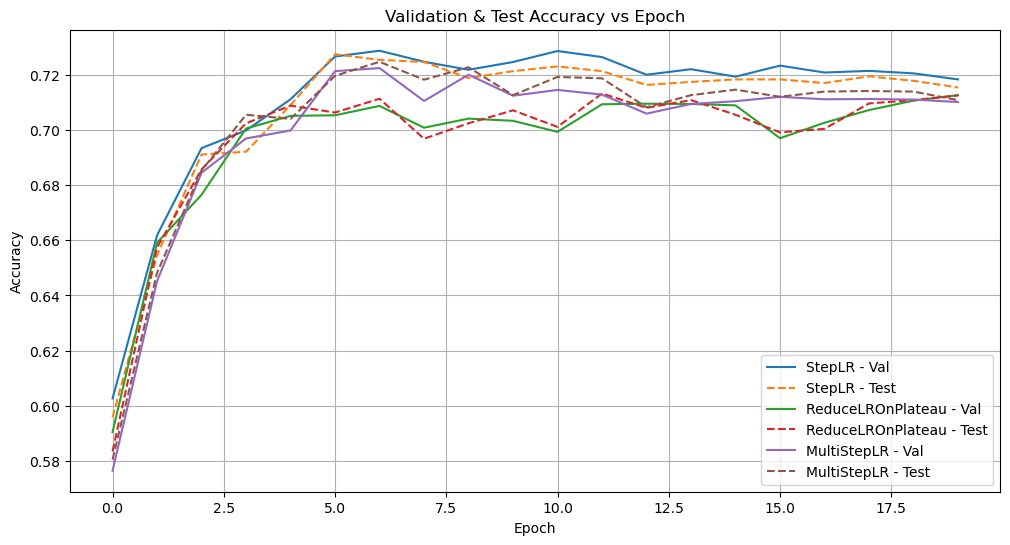

In [5]:
results = {}
for scheduler_type in ["StepLR", "ReduceLROnPlateau", "MultiStepLR"]:
    results[scheduler_type] = train_model(scheduler_type)
plot_results(results)



## Transfer learning

Transfer learning to technika w uczeniu maszynowym, która polega na wykorzystaniu wiedzy zdobytej przez model, wytrenowany na jednym zadaniu, do rozwiązania innego, ale powiązanego zadania. Jest to szczególnie przydatne w głębokim uczeniu, gdzie trenowanie modeli od podstaw wymaga dużych ilości danych i zasobów obliczeniowych. Transfer learning pozwala zaoszczędzić czas i poprawić wydajność modelu, zwłaszcza gdy dostępny zbiór danych jest ograniczony.


### Zalety:

* Oszczędność zasobów: Modele wstępnie wytrenowane na dużych zbiorach danych (np. ImageNet) zawierają już ogólne cechy, które można wykorzystać w nowych zadaniach.

* Szybsze uczenie: Zamiast trenować model od zera, dostosowujemy tylko niektóre warstwy, co skraca czas treningu.

* Dobra generalizacja nawet przy małej ilości danych.

### Jak działa transfer learning?

1. Wybieramy wytrenowany model (np. ResNet-32), najczęściaj na jakimś dużym zbiorze danych (np. ImageNet).

2. Zamrażamy część warstw modelu, aby zachować ich wyuczone cechy. Zazwyczaj zamraża się warstwy konwolucyjne w modelach wizyjnych lub warstwy transformera w modelach językowych.

3. Zastępujemy lub dostosowujemy warstwy końcowe modelu (np. warstwę klasyfikacyjną) do nowego zadania. Na przykład, dla klasyfikacji obrazów zmieniamy warstwę wyjściową, aby odpowiadała liczbie klas w nowym zbiorze danych.

4. Fine-tuning: Opcjonalnie, po wstępnym treningu z zamrożonymi warstwami, możemy odblokować niektóre warstwy i trenować je z małą stałą uczącą, aby lepiej dostosować model do nowego zadania.

### Przykłady zastosowań

* Rozpoznawanie obrazów: Użycie ResNet-50 wytrenowanego na ImageNet do klasyfikacji zdjęć medycznych (np. wykrywanie raka na zdjęciach rentgenowskich).

* Przetwarzanie języka naturalnego: Użycie BERT do analizy sentymentu lub klasyfikacji tekstu na podstawie małego zbioru danych.

* Rozpoznawanie dźwięku: Wykorzystanie wstępnie wytrenowanych modeli do wykrywania określonych dźwięków w nagraniach.

## Popularne modele używane w transfer learningu:

* VGG: Prosty, ale skuteczny model z głębokimi warstwami konwolucyjnymi.

* ResNet: Wprowadza połączenia rezydualne, co ułatwia trening bardzo głębokich sieci.

* EfficientNet.

* BERT: Transformer do zadań takich, jak klasyfikacja tekstu, czy odpowiadanie na pytania.

## Augmentacja danych (na bazie materiału przygotowanego przez Mikołaja Janusza)
Polega na sztucznym zwiększeniu zbioru danych treningowych poprzez różne transformacje obrazów. Ważne jest, aby transformacja nie wpływała na etykiety obrazów (np. klasyfikowany obiekt), ale jednocześnie wprowadzała różnorodność do zbioru danych. Technika ta może też redukować ryzyko uprzedzenia (ang. bias) modelu, które może wynikać z ograniczonej różnorodności danych treningowych. Przykładowo transformacja koloru ogranicza bias, w którym model przewiduje ptaki czy samoloty na podstawie niebieskiego tła (nieba), a nie samego obiektu.

Istnieją różne techniki augmentacji danych, takie jak:

* Losowe wycięcie (ang. RandomCrop): czyli wycięcie losowego fragmentu obrazka.

* Odbicie poziome (ang. HorizontalFlip): z pewnym prawdopodobieństwiem (np. 0.5) tworzone jest odbicie lustrzane względem osii pionowej. Te transformacje wprowadzają różne warianty pozycji i orientacji obiektu.

Innymi typami transformacji są transformacje koloru (zmiana wartości kanałów RGB), np. w przypadku AlexNet autorzy wykonali tak zwane PCA Color Augmentation. W uproszczeniu dodawali oni losowe wartości do kanałów RGB, które były wyznaczane na podstawie analizy danych (za pomocą PCA).

Augmentację te można oczywiście łączyć i wykonywać jedna po drugiej, w praktyce implementowane jest to jako "Pipeline", czyli po kolei wykonujemy transformacje na wejściu.

Istnieje ogromna ilość augmentacji (transformacji) danych, są one głównie zależne od typu danych, jaki mamy (istnieją też augmentacje dla grafów, tekstu i innych modalności niż wizja).

Augmentacja danych jest też kluczowym elementem jednej z technik uczenia nienadzorowanego tak zwanego "self-supervised learning" (uczenie samonadzorowane), w której model uczy się reprezentacji danych na podstawie augmentacji danych. W architekturze SimCLR, gdzie, w uproszczeniu, model próbuję przewidzieć czy dwa różne augmentacje pochodzą z tego samego obrazka, model w ten sposób uczy się reprezentacji różnych cech obrazów.

Przed transformacją:


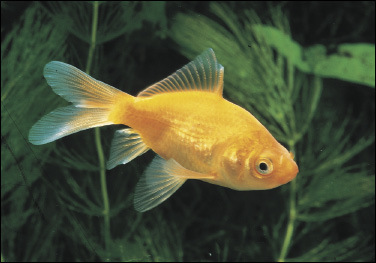

In [2]:
img_path = Path("images/goldfish.jpeg")  # Wczytaj obrazek z pliku
image = Image.open(img_path)  # Wczytaj obrazek z pliku

print("Przed transformacją:")
display(image)  # Wyświetl obrazek

Przykłady po transformacji:


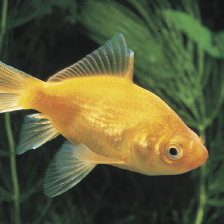

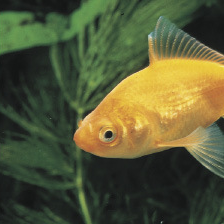

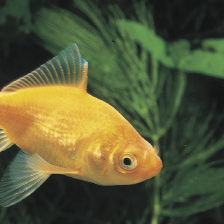

In [3]:
# Zdefiniuj pipeline transformacji
transform = transforms.Compose(
    [
        transforms.RandomCrop(224),  # wytnij skrawek 224x224 pikseli
        transforms.RandomHorizontalFlip(
            p=0.5
        ),  # Z prawdopodobieństwiem 0.5 wykonaj odbicie poziome
        transforms.ToTensor(),  # Przerób obrazek na Tensor
        # W praktyce stosuję się również normalizację
        # transforms.Normalize(
        #    mean=[0.485, 0.456, 0.406],
        #    std=[0.229, 0.224, 0.225],
        # ),
    ]
)

# Przeprowadź transformację
print("Przykłady po transformacji:")
for _ in range(3):
    transformed_image = transform(image)
    transformed_image_pil = transforms.ToPILImage()(transformed_image)
    display(transformed_image_pil)

**Bonus**: Istnieją badziej zaawansowane augmentacje danych, takie jak CutMix czy MixUp. Różnią się one od standardowych transformacji tym, że działają na wielu danych wejściowych.

CutMix wycina fragment jednego obrazka i wkleja go w inny obrazek, tak naprawdę mieszając dwa obrazki. Następnie etykiety są również mieszane w proporcjach wielkości wycinka do reszty obrazka. Poprawia to umiejętności lokalizowania modelu (ang. localization ability) i generalizuje model.

MixUp jest dość skomplikowany, ale w uproszczeniu transformacja ta przeprowadza interpolację pomiędzy dwoma obrazkami i ich etykietami.

[Wizualizacja MixUp](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*Yk9osx3VnNh16zjdmMwfJg.png)

### Zadanie nr 4 (4 punkty)

Zaimplementuj model klasyfikacji obrazów na zbiorze danych CIFAR-10, wykorzystując pretrenowany model [ResNet-18](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html) na zbiorze danych ImageNet. Instrukcje do zrealizowania:

1. Wczytaj zbiór danych CIFAR-10 za pomocą *torchvision.datasets.CIFAR10*. Następnie podziel je na treningowe, walidacyjne i testowe w sensownych proporcjach.

2. Na zbiorze treningowym wykonaj augmentację danych (3 dowolne augmentacje, ale nie takie same) i przeprowadź standaryzację. Pamiętaj, że dane ze zbioru walidacyjnego i testowego również muszą zostać poddane standaryzacji (ale nie augmentacji!).

3. Napisz pętlę treningową (10 epok, optymalizator Adam, stała ucząca 0.001) i użyj pretrenowanego modelu ResNet-18 z *torchvision.models* tak, że:

* Wszystkie warstwy modelu są zamrożone, poza ostatnią warstwą klasyfikacyjną. Proszę pamiętać o dopasowaniu liczby klas do aktualnego problemu! 

* Po zrealizowaniu kropki powyżej proszę odmrozić wszystkie warstwy modelu i zrobić fine-tuning dla małej stałej uczącej (np. 1e-5) przez 4 epoki.

4. Stwórz wykresy ilustrujące przebieg nauki na zbiorze walidacyjnym, treningowym i testowym. Proszę zaznaczyć epokę, od której rozpoczął się fine-tuning.

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

# CIFAR-10: 50k train, 10k test
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

full_train = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
test_set = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_val_transform)

train_len = int(0.8 * len(full_train))
val_len = len(full_train) - train_len
train_set, val_set = random_split(full_train, [train_len, val_len])
val_set.dataset.transform = test_val_transform  # disable augmentations

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)


In [18]:
import torchvision.models as models
import torch.nn as nn

def get_resnet18(freeze=True):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    if freeze:
        for param in model.parameters():
            param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10
    return model


In [19]:
from torch.optim import Adam
import matplotlib.pyplot as plt

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return correct / total

def train_resnet18():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_resnet18(freeze=True).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

    train_accs, val_accs, test_accs = [], [], []

    for epoch in range(10):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        train_accs.append(evaluate(model, train_loader, device))
        val_accs.append(evaluate(model, val_loader, device))
        test_accs.append(evaluate(model, test_loader, device))
        print(f"[E{epoch+1}/10] Train={train_accs[-1]:.4f}, Val={val_accs[-1]:.4f}, Test={test_accs[-1]:.4f}")

    # Fine-tuning
    print("🔓 Unfreezing all layers...")
    for param in model.parameters():
        param.requires_grad = True

    optimizer = Adam(model.parameters(), lr=1e-5)

    for epoch in range(10, 14):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        train_accs.append(evaluate(model, train_loader, device))
        val_accs.append(evaluate(model, val_loader, device))
        test_accs.append(evaluate(model, test_loader, device))
        print(f"[Fine-Tune E{epoch+1}/14] Train={train_accs[-1]:.4f}, Val={val_accs[-1]:.4f}, Test={test_accs[-1]:.4f}")

    return train_accs, val_accs, test_accs


In [20]:
def plot_learning_curves(train_accs, val_accs, test_accs, fine_tune_start=10):
    epochs = list(range(1, len(train_accs)+1))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accs, label="Train Acc")
    plt.plot(epochs, val_accs, label="Val Acc")
    plt.plot(epochs, test_accs, label="Test Acc")
    plt.axvline(fine_tune_start, linestyle="--", color="gray", label="Fine-Tune Start")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("ResNet-18 Transfer Learning on CIFAR-10")
    plt.legend()
    plt.grid(True)
    plt.show()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/msztu223/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:28<00:00, 1.67MB/s]


[E1/10] Train=0.4610, Val=0.4502, Test=0.4422
[E2/10] Train=0.4609, Val=0.4458, Test=0.4415
[E3/10] Train=0.4691, Val=0.4523, Test=0.4497
[E4/10] Train=0.4854, Val=0.4714, Test=0.4609
[E5/10] Train=0.4728, Val=0.4557, Test=0.4519
[E6/10] Train=0.4813, Val=0.4620, Test=0.4563
[E7/10] Train=0.4767, Val=0.4555, Test=0.4491
[E8/10] Train=0.4673, Val=0.4451, Test=0.4403
[E9/10] Train=0.4840, Val=0.4591, Test=0.4536
[E10/10] Train=0.4742, Val=0.4553, Test=0.4499
🔓 Unfreezing all layers...
[Fine-Tune E11/14] Train=0.6250, Val=0.5807, Test=0.5671
[Fine-Tune E12/14] Train=0.6945, Val=0.6294, Test=0.6228
[Fine-Tune E13/14] Train=0.7418, Val=0.6651, Test=0.6558
[Fine-Tune E14/14] Train=0.7791, Val=0.6817, Test=0.6791


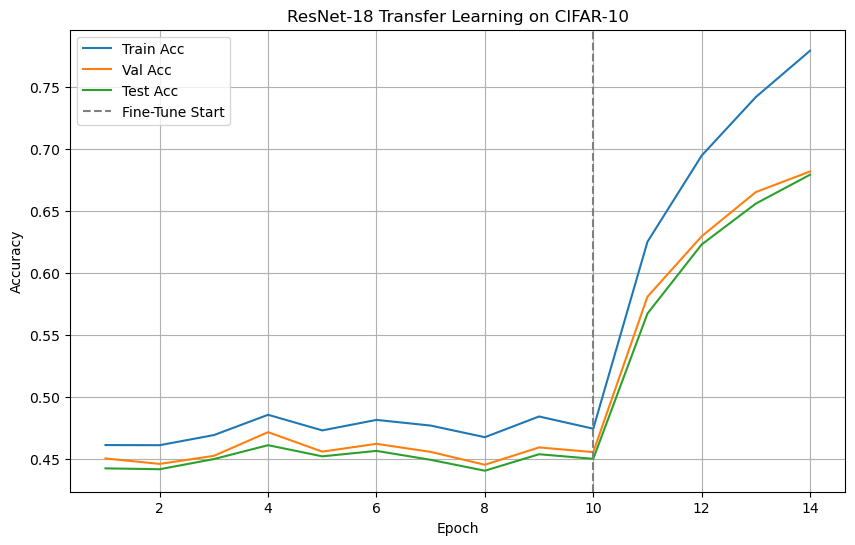

In [21]:
train_accs, val_accs, test_accs = train_resnet18()
plot_learning_curves(train_accs, val_accs, test_accs, fine_tune_start=10)
